### Keras RNN으로 여행자수 예측

1. 패키지 수입 및 파라미터 설정

In [1]:
# 수입
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.layers import Dense
from keras.layers import LSTM, InputLayer
from keras.models import Sequential
from sklearn.model_selection import train_test_split

In [2]:
# 파라미터
MY_PAST = 12          # 입력수
MY_SPLIT = 0.8        # 학습 비율
MY_HIDDEN = 300       # 뉴런 개수
MY_SHAPE = (MY_PAST, 1)     # RNN에 들어가는 모양, LSTM에 들어가는 숫자가 단독적으로 하나의 차원을 이루면서 들어가야해서 뒤에 ,1을 넣어줌으로써 차원을 맞춰준다.
MY_EPOCH = 150        # 학습

2. 데이터 처리

In [3]:
# 데이터 읽기
raw = pd.read_csv('/content/drive/MyDrive/data/airline.csv',
                  header=None,
                  usecols=[1])

# 샘플 출력
print(raw.head(15))
print(raw.describe())

      1
0   112
1   118
2   132
3   129
4   121
5   135
6   148
7   148
8   136
9   119
10  104
11  118
12  115
13  126
14  141
                1
count  144.000000
mean   280.298611
std    119.966317
min    104.000000
25%    180.000000
50%    265.500000
75%    360.500000
max    622.000000


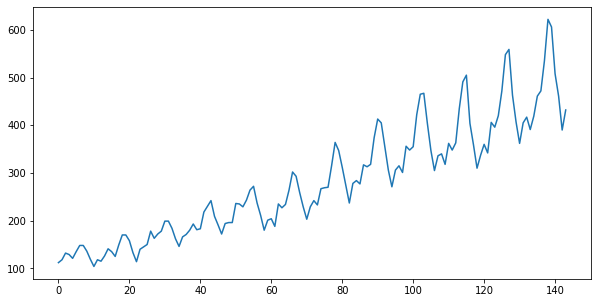

In [4]:
plt.figure(figsize=(10, 5))
plt.plot(raw)

<class 'numpy.ndarray'>
[0.01544402 0.02702703 0.05405405 0.04826255 0.03281853 0.05984556
 0.08494208 0.08494208 0.06177606 0.02895753 0.         0.02702703
 0.02123552 0.04247104 0.07142857 0.05984556 0.04054054 0.08687259
 0.12741313 0.12741313 0.1042471  0.05598456 0.01930502 0.06949807
 0.07915058 0.08880309 0.14285714 0.11389961 0.13127413 0.14285714
 0.18339768 0.18339768 0.15444015 0.11196911 0.08108108 0.11969112
 0.12934363 0.14671815 0.17181467 0.14864865 0.15250965 0.22007722
 0.24324324 0.26640927 0.2027027  0.16795367 0.13127413 0.17374517
 0.17760618 0.17760618 0.25482625 0.25289575 0.24131274 0.26833977
 0.30888031 0.32432432 0.25675676 0.20656371 0.14671815 0.18725869
 0.19305019 0.16216216 0.25289575 0.23745174 0.25096525 0.30888031
 0.38223938 0.36486486 0.2992278  0.24131274 0.19111969 0.24131274
 0.26640927 0.24903475 0.31467181 0.31853282 0.32046332 0.40733591
 0.5019305  0.46911197 0.4015444  0.32818533 0.25675676 0.33590734
 0.34749035 0.33397683 0.41119691 0.40

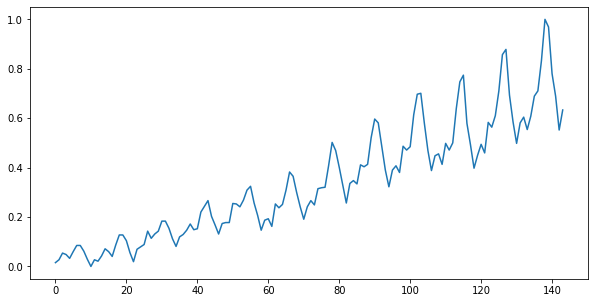

In [5]:
# 데이터 정규화
scaler = MinMaxScaler()                 # MinMaxScale : 0~1의 값으로 정규화

#scaler = StandardScaler()
s_data = scaler.fit_transform(raw)      # 정규화된 데이터

#s_data = (s_data - 0.5) *2

print(type(s_data))
print(s_data.flatten())
plt.figure(figsize=(10, 5))
plt.plot(s_data)

In [6]:
# 데이터 분할
data = []
for i in range(len(s_data) - MY_PAST):          # s_data(총 데이터 수): 144 ,MT_PAST: 입력 수(12달치)
    data.append(s_data[i: i + MY_PAST + 1])     # p.147, 시계열 데이터 분할 코딩
                                                # 한 묶음 수: 13
print('한 묶음의 크기:', len(data[0]))
print('총 묶음의 수:', len(data))
print('첫번째 묶음 내용\n', data[0])

한 묶음의 크기: 13
총 묶음의 수: 132
첫번째 묶음 내용
 [[0.01544402]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]
 [0.05984556]
 [0.08494208]
 [0.08494208]
 [0.06177606]
 [0.02895753]
 [0.        ]
 [0.02702703]
 [0.02123552]]


In [7]:
# 데이터를 numpy로 전환
print(type(data))
data = np.array(data)     # list에서는 못하는 것을 numpy에서는 자유롭게 활용이 가능해서 변경해준다.
print(type(data))

# 묶음들을 임의로 섞음
#np.random.shuffle(data)     # 데이터 안의 숫자는 시계열이 유지되기 때문에 순서를 바꿔도 된다. -> 섞으면 오히려 학습이 잘됨
print(data.shape)           # 3차원 데이터 : 숫자 하나당 하나의 개별적인 차원을 가지고 있다.

# 데이터를 입력과 출력으로 분할
X_data = data[:,:MY_PAST]            # data[총 몇행,몇열], : -> 행을 처음부터 끝까지 다 취한다.(0:132)
Y_data = data[:,-1]

print('입력 데이터 모양:', X_data.shape)
print('출력 데이터 모양:', Y_data.shape)

<class 'list'>
<class 'numpy.ndarray'>
(132, 13, 1)
입력 데이터 모양: (132, 12, 1)
출력 데이터 모양: (132, 1)


In [8]:
# 데이터 4분할
X_train, X_test, Y_train, Y_test = train_test_split(X_data, 
                                                    Y_data,
                                                    train_size = MY_SPLIT,
                                                    shuffle = False)

# 최종 데이터 모양 출력
print('학습용 입력 데이터 모양 : ', X_train.shape)
print('학습용 출력 데이터 모양 : ', Y_train.shape)
print('평가용 입력 데이터 모양 : ', X_test.shape)
print('평가용 출력 데이터 모양 : ', Y_test.shape)

학습용 입력 데이터 모양 :  (105, 12, 1)
학습용 출력 데이터 모양 :  (105, 1)
평가용 입력 데이터 모양 :  (27, 12, 1)
평가용 출력 데이터 모양 :  (27, 1)


3. 인공 신경망 구현

In [9]:
# RNN 구현
model = Sequential()

model.add(InputLayer(input_shape=MY_SHAPE))

model.add(LSTM(units=MY_HIDDEN))

model.add(Dense(units=1,
                activation='sigmoid'))

print('RNN 요약')
model.summary()

RNN 요약
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 300)               362400    
_________________________________________________________________
dense (Dense)                (None, 1)                 301       
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


4. 인공 신경망 학습

In [10]:
# RNN 학습 설정
model.compile(optimizer='adam',
              loss='mse')

print('학습 시작')
begin = time()

model.fit(x=X_train,
          y=Y_train,
          epochs=MY_EPOCH,
          verbose=0)

end = time()
print('학습 시간 : {:.2f}'.format(end-begin))

학습 시작
학습 시간 : 5.02


5. 인공 신경망 평가

In [11]:
# RNN 평가
score = model.evaluate(x=X_test,
                       y=Y_test,
                       verbose=0)

print('최종 손실값:', score)

최종 손실값: 0.009298263117671013


6. 인공 신경망 예측

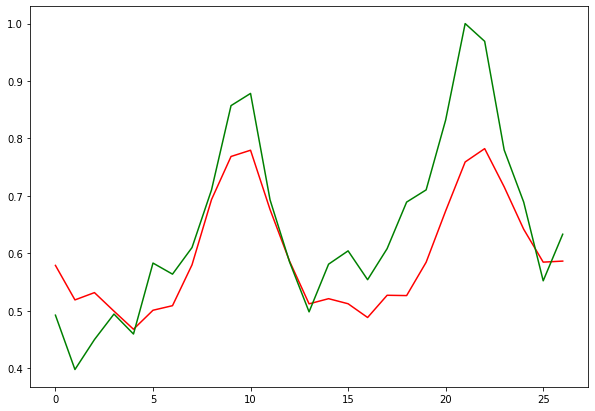

In [12]:
# RNN으로 예측
pred = model.predict(x=X_test)

# 예측 결과 및 정답 그래프 그리기
plt.figure(figsize=(10, 7))
plt.plot(pred, 'r')       # 추측
plt.plot(Y_test, 'g')     # 정답

In [13]:
print('역전환 전:', pred)
print(pred.shape)

# 데이터 역전환
pred = scaler.inverse_transform(pred)

print('역전환 후:', pred)
print(pred.shape)

# squeeze 결과          
tmp = np.squeeze(pred).astype(int)    # squeeze : 1차원으로 변경, astype : type 변경(정수형으로)
print('squeeze 후:', tmp)
print(tmp.shape)

역전환 전: [[0.57894206]
 [0.5188646 ]
 [0.53155744]
 [0.4992906 ]
 [0.4677995 ]
 [0.5008568 ]
 [0.50880575]
 [0.579913  ]
 [0.6935674 ]
 [0.7685926 ]
 [0.7794738 ]
 [0.6761659 ]
 [0.58628523]
 [0.51198745]
 [0.5210051 ]
 [0.51216364]
 [0.4882403 ]
 [0.5269312 ]
 [0.52639097]
 [0.58443964]
 [0.67377645]
 [0.7590406 ]
 [0.78224534]
 [0.7157129 ]
 [0.6418929 ]
 [0.5846351 ]
 [0.5864282 ]]
(27, 1)
역전환 후: [[403.892  ]
 [372.77185]
 [379.34677]
 [362.63254]
 [346.32016]
 [363.44385]
 [367.5614 ]
 [404.39496]
 [463.2679 ]
 [502.13098]
 [507.76743]
 [454.25394]
 [407.69577]
 [369.2095 ]
 [373.88065]
 [369.30078]
 [356.90848]
 [376.95038]
 [376.67053]
 [406.73975]
 [453.0162 ]
 [497.18304]
 [509.2031 ]
 [474.7393 ]
 [436.50055]
 [406.84097]
 [407.76984]]
(27, 1)
squeeze 후: [403 372 379 362 346 363 367 404 463 502 507 454 407 369 373 369 356 376
 376 406 453 497 509 474 436 406 407]
(27,)


역전환 전 정답 [[0.49227799]
 [0.3976834 ]
 [0.44980695]
 [0.49420849]
 [0.45945946]
 [0.58301158]
 [0.56370656]
 [0.61003861]
 [0.71042471]
 [0.85714286]
 [0.87837838]
 [0.69305019]
 [0.58494208]
 [0.4980695 ]
 [0.58108108]
 [0.6042471 ]
 [0.55405405]
 [0.60810811]
 [0.68918919]
 [0.71042471]
 [0.83204633]
 [1.        ]
 [0.96911197]
 [0.77992278]
 [0.68918919]
 [0.55212355]
 [0.63320463]]
역전환 후 정답 [[359.]
 [310.]
 [337.]
 [360.]
 [342.]
 [406.]
 [396.]
 [420.]
 [472.]
 [548.]
 [559.]
 [463.]
 [407.]
 [362.]
 [405.]
 [417.]
 [391.]
 [419.]
 [461.]
 [472.]
 [535.]
 [622.]
 [606.]
 [508.]
 [461.]
 [390.]
 [432.]]


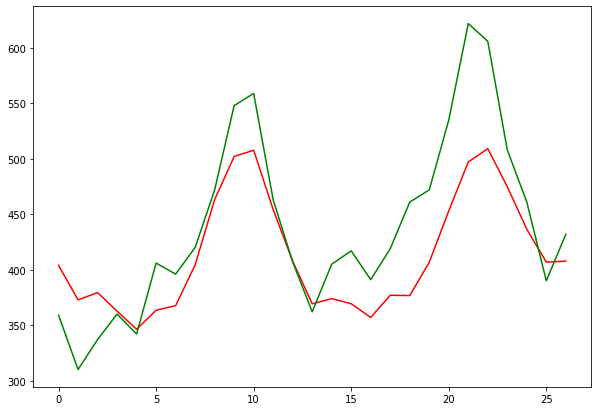

In [14]:
# 정답 출력
print('역전환 전 정답', Y_test)
Y_test = scaler.inverse_transform(Y_test)
print('역전환 후 정답', Y_test)

# 예측 결과 및 정답 그래프 그리기 -> y축의 범위가 다르다
plt.figure(figsize=(10, 7))
plt.plot(pred, 'r')       # 추측
plt.plot(Y_test, 'g')     # 정답